In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [6]:
filename='tax_history_2007to2017_v2.parq'

In [7]:
data=dd.read_parquet("../input/"+filename).drop(
    ['landappraisedvalue','improvementappraisedvalue','taxdelinquencyamount','totalappraisedvalue'],axis=1
).compute().set_index("parcelid")

In [8]:
set(data.assessmentyear)

{2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}

In [9]:
years=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [10]:
data_dict={u:data[data['assessmentyear']==u] for u in 
           years}

In [11]:
for i in years:
    print i, data_dict[i].shape[0]

2007 7105306
2008 7515539
2009 7478566
2010 8488125
2011 8549798
2012 8272524
2013 7812099
2014 7232700
2015 9164824
2016 9247415
2017 4065330


In [12]:
lst=[]
for i in years:
    lst.append(data_dict[i].isnull().mean())
tmpdf=pd.concat(lst,axis=1)
tmpdf.columns=years
tmpdf

2007      2008      2009      2010      2011  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.683990  0.737877  0.737621  0.704012  0.712672   
improvementmarketvalue      0.424661  0.402510  0.408479  0.383603  0.383627   
structuretaxvaluedollarcnt  0.067711  0.054992  0.058420  0.050093  0.051034   
totalassessedvalue          0.219613  0.150701  0.099067  0.072058  0.070612   
taxamount                   0.575132  0.575870  0.654750  0.627014  0.629642   
taxvaluedollarcnt           0.040750  0.030856  0.029068  0.026480  0.026351   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.251700  0.180233  0.143670  0.129211  0.134850   
taxdelinquencyyear          0.997352  0.997011  0.996091  0.995550  0.991622   
totalmarketvalue            0.406914  0.385245  0.388990  0.368253  0.368522   
improvementassessedvalue    0.267371  0.195048  0.156857  0.140622  0.144691   
landtaxvaluedollarcnt       0.049685  0.037855  0.044415  0.035492  0.039652   
landmarketvalue             0.412134  0.390488  0.398839  0.373002  0.375322   

                                2012      2013      2014      2015      2016  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.723013  0.723186  0.665045  0.697708  0.704632   
improvementmarketvalue      0.407571  0.376633  0.373293  0.361756  0.349868   
structuretaxvaluedollarcnt  0.052449  0.042305  0.049277  0.057342  0.049646   
totalassessedvalue          0.065713  0.061896  0.035447  0.024813  0.023113   
taxamount                   0.639455  0.585276  0.040500  0.034986  0.035828   
taxvaluedollarcnt           0.026066  0.024883  0.004707  0.006067  0.005889   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.137446  0.131954  0.131864  0.125427  0.126486   
taxdelinquencyyear          0.976005  0.707902  0.952825  0.959981  0.960704   
totalmarketvalue            0.391171  0.362952  0.353909  0.342746  0.324949   
improvementassessedvalue    0.149567  0.140057  0.140368  0.131857  0.130711   
landtaxvaluedollarcnt       0.040136  0.032719  0.036469  0.047684  0.043183   
landmarketvalue             0.397880  0.368272  0.361578  0.352419  0.342997   

                                2017  
assessmentyear              0.000000  
taxratecodearea             0.902714  
improvementmarketvalue      0.618278  
structuretaxvaluedollarcnt  0.058741  
totalassessedvalue          0.014937  
taxamount                   0.039878  
taxvaluedollarcnt           0.009527  
edition                     0.000000  
landassessedvalue           0.145240  
taxdelinquencyyear          0.977968  
totalmarketvalue            0.575878  
improvementassessedvalue    0.148469  
landtaxvaluedollarcnt       0.051295  
landmarketvalue             0.608652

In [13]:
def get_col(col):
    df=pd.concat([data_dict[i][col] for i in years],axis=1)
    df.columns=years
    return df

In [14]:
print "Are there ones whose tax is not null but taxvalue is null?"
a=get_col("taxamount")
b=get_col("taxvaluedollarcnt")

Are there ones whose tax is not null but taxvalue is null?


In [19]:
for year in years:
    aa=a.loc[:,year]
    bb=b.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    num=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    print year,num,ab.shape[0],float(num)/ab.shape[0]
    #break

2007 255376 9463095 0.026986519738
2008 200901 9463095 0.0212299464393
2009 199212 9463095 0.0210514636068
2010 200275 9463095 0.0211637947204
2011 205161 9463095 0.0216801162833
2012 196034 9463095 0.0207156326762
2013 164211 9463095 0.0173527794025
2014 19215 9463095 0.0020305196133
2015 35561 9463095 0.00375786146076
2016 33218 9463095 0.00351026804655
2017 25563 9463095 0.00270133608508


In [45]:
print "how assesed values varies with market value?"
c=get_col('totalassessedvalue')
d=get_col('totalmarketvalue')

how assesed values varies with market value?


In [30]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],4)

2007 2601706 1270876 2943180 7105306 [ 0.3662  0.1789  0.4142  0.0408]
2008 2663423 900696 3719519 7515539 [ 0.3544  0.1198  0.4949  0.0309]
2009 2691700 523490 4045986 7478566 [ 0.3599  0.07    0.541   0.0291]
2010 2901014 386877 4975472 8488125 [ 0.3418  0.0456  0.5862  0.0265]
2011 2925492 378421 5020591 8549798 [ 0.3422  0.0443  0.5872  0.0264]
2012 3020336 327977 4708579 8272524 [ 0.3651  0.0396  0.5692  0.0261]
2013 2641024 289147 4687536 7812099 [ 0.3381  0.037   0.6     0.0249]
2014 2525672 222332 4450649 7232700 [ 0.3492  0.0307  0.6154  0.0047]
2015 3085606 171798 5851815 9164824 [ 0.3367  0.0187  0.6385  0.0061]
2016 2950486 159285 6083190 9247415 [ 0.3191  0.0172  0.6578  0.0059]
2017 2302405 21995 1702201 4065330 [ 0.5664  0.0054  0.4187  0.0095]


In [37]:
print "except 2017, totalassessedvalue has 30+% exclusive percentage, totalmarketvalue (exclusive) reduced to less 2%  "

except 2017, totalassessedvalue has 30+% exclusive percentage, totalmarketvalue (exclusive) reduced to less 2%  


In [36]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 2943180 232 2042644 7105306 [ 0.414  0.     0.694  0.306]
2008 3719519 2980 2749522 7515539 [ 0.495  0.001  0.739  0.26 ]
2009 4045986 303 2751856 7478566 [ 0.541  0.     0.68   0.32 ]
2010 4975472 10068 3344814 8488125 [ 0.586  0.002  0.672  0.326]
2011 5020591 4062 3252274 8549798 [ 0.587  0.001  0.648  0.351]
2012 4708579 6285 3021720 8272524 [ 0.569  0.001  0.642  0.357]
2013 4687536 3810 2987707 7812099 [ 0.6    0.001  0.637  0.362]
2014 4450649 7601 2715303 7232700 [ 0.615  0.002  0.61   0.388]
2015 5851815 29833 3724692 9164824 [ 0.639  0.005  0.637  0.358]
2016 6083190 21892 3832514 9247415 [ 0.658  0.004  0.63   0.366]
2017 1702201 5591 82814 4065330 [ 0.419  0.003  0.049  0.948]


In [38]:
print """
    Except 2017, totalassessedvalue almost never greater than totalmarketvalue; they are equal for 30+%  
"""


    Except 2017, totalassessedvalue almost never greater than totalmarketvalue; they are equal for 30+%  



look at their difference
2007 2943180 2042876 [ 0.414  0.694]


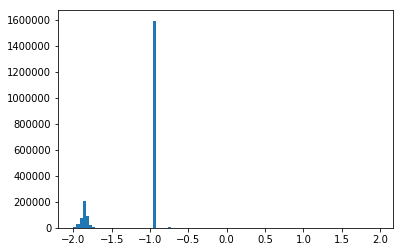

2008 3719519 2752502 [ 0.495  0.74 ]


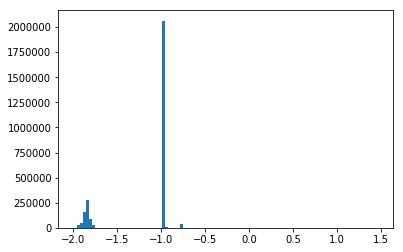

2009 4045986 2752159 [ 0.541  0.68 ]


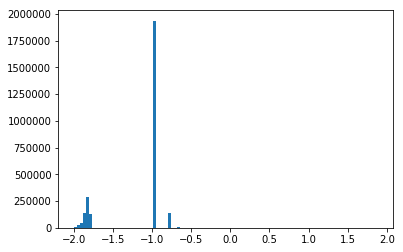

2010 4975472 3354882 [ 0.586  0.674]


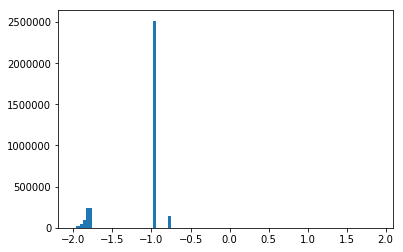

2011 5020591 3256336 [ 0.587  0.649]


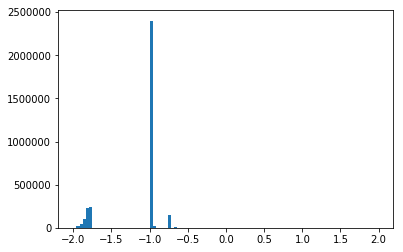

2012 4708579 3028005 [ 0.569  0.643]


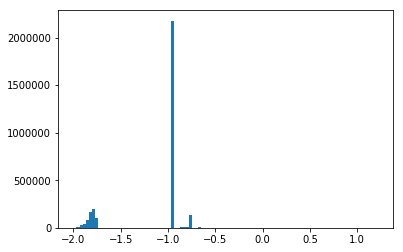

2013 4687536 2991517 [ 0.6    0.638]


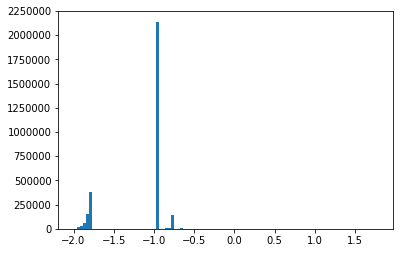

2014 4450649 2722904 [ 0.615  0.612]


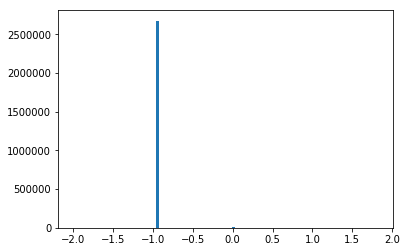

2015 5851815 3754525 [ 0.639  0.642]


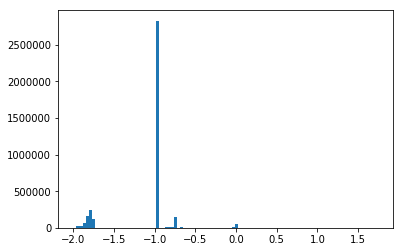

2016 6083190 3854406 [ 0.658  0.634]


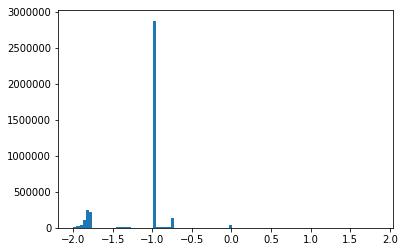

2017 1702201 88405 [ 0.419  0.052]


In [50]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [51]:
print """
    When the two values are not equal, their difference is very large. In the current settings, maximum of them is
    taken. Given that totalassessvalue is about 30+%  weights. tradeoff between of them is signidicant.
    Examintation should be made on their relationshape with sale price.
"""


    When the two values are not equal, their difference is very large. In the current settings, maximum of them is
    taken. Given that totalassessvalue is about 30+%  weights. tradeoff between of them is signidicant.
    Examintation should be made on their relationshape with sale price.



### landassessedvalue vs  landmarketvalue

In [54]:
print "how assesed values varies with market value?"
c=get_col('landassessedvalue')
d=get_col('landmarketvalue')

how assesed values varies with market value?


In [55]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],4)

2007 2575309 1435376 2741594 7105306 [ 0.3624  0.202   0.3859  0.0497]
2008 2650229 1070050 3510759 7515539 [ 0.3526  0.1424  0.4671  0.0379]
2009 2650582 742285 3753539 7478566 [ 0.3544  0.0993  0.5019  0.0444]
2010 2864831 795505 4526531 8488125 [ 0.3375  0.0937  0.5333  0.0355]
2011 2869914 813923 4526945 8549798 [ 0.3357  0.0952  0.5295  0.0397]
2012 2959446 805001 4176052 8272524 [ 0.3577  0.0973  0.5048  0.0401]
2013 2621374 775232 4159889 7812099 [ 0.3356  0.0992  0.5325  0.0327]
2014 2351418 689967 3927546 7232700 [ 0.3251  0.0954  0.543   0.0365]
2015 2792842 712497 5222466 9164824 [ 0.3047  0.0777  0.5698  0.0477]
2016 2772508 770337 5305240 9247415 [ 0.2998  0.0833  0.5737  0.0432]
2017 2265840 381915 1209043 4065330 [ 0.5574  0.0939  0.2974  0.0513]


In [56]:
print "except 2017, totalassessedvalue has 30+% exclusive percentage, totalmarketvalue (exclusive) reduced to less 9%  "

except 2017, totalassessedvalue has 30+% exclusive percentage, totalmarketvalue (exclusive) reduced to less 9%  


In [57]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 2741594 72 2034896 7105306 [ 0.386  0.     0.742  0.258]
2008 3510759 29 2735090 7515539 [ 0.467  0.     0.779  0.221]
2009 3753539 56 2734164 7478566 [ 0.502  0.     0.728  0.272]
2010 4526531 168 3328156 8488125 [ 0.533  0.     0.735  0.265]
2011 4526945 29 3228779 8549798 [ 0.529  0.     0.713  0.287]
2012 4176052 282 2998471 8272524 [ 0.505  0.     0.718  0.282]
2013 4159889 311 2964894 7812099 [ 0.532  0.     0.713  0.287]
2014 3927546 610 2687245 7232700 [ 0.543  0.     0.684  0.316]
2015 5222466 22032 3693495 9164824 [ 0.57   0.004  0.707  0.289]
2016 5305240 17707 3745526 9247415 [ 0.574  0.003  0.706  0.291]
2017 1209043 5 19792 4065330 [ 0.297  0.     0.016  0.984]


In [58]:
print """
    Except 2017, totalassessedvalue almost never greater than totalmarketvalue; they are equal for 70+%  
"""


    Except 2017, totalassessedvalue almost never greater than totalmarketvalue; they are equal for 70+%  



look at their difference
2007 2741594 2034968 [ 0.386  0.742]


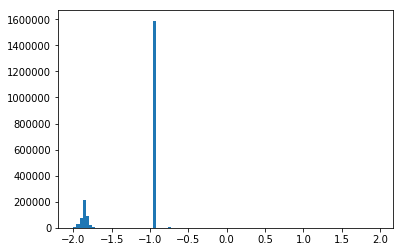

2008 3510759 2735119 [ 0.467  0.779]


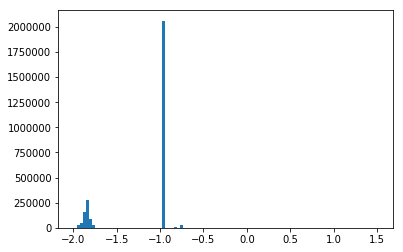

2009 3753539 2734220 [ 0.502  0.728]


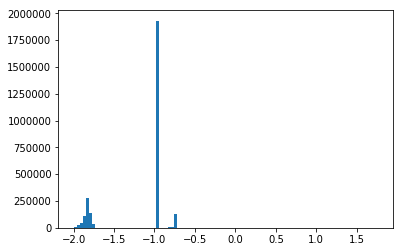

2010 4526531 3328324 [ 0.533  0.735]


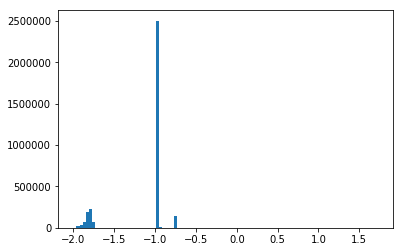

2011 4526945 3228808 [ 0.529  0.713]


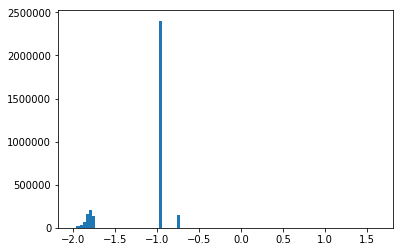

2012 4176052 2998753 [ 0.505  0.718]


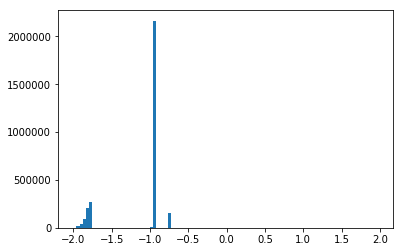

2013 4159889 2965205 [ 0.532  0.713]


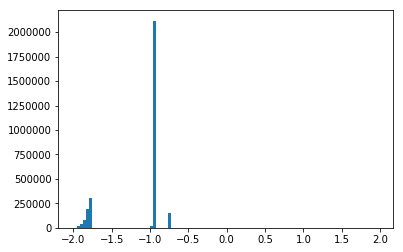

2014 3927546 2687855 [ 0.543  0.684]


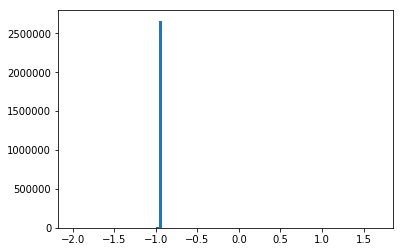

2015 5222466 3715527 [ 0.57   0.711]


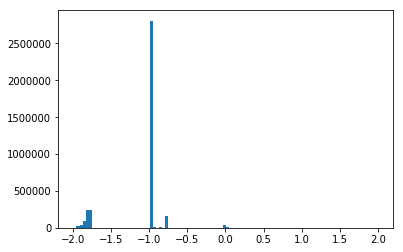

2016 5305240 3763233 [ 0.574  0.709]


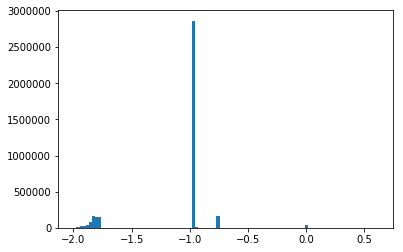

2017 1209043 19797 [ 0.297  0.016]


In [59]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [60]:
print """
    When the two values are not equal, their difference is very large. In the current settings, maximum of them is
    taken. Given that totalassessvalue is about 30+%  weights. tradeoff between of them is signidicant.
    Examintation should be made on their relationshape with sale price.
"""


    When the two values are not equal, their difference is very large. In the current settings, maximum of them is
    taken. Given that totalassessvalue is about 30+%  weights. tradeoff between of them is signidicant.
    Examintation should be made on their relationshape with sale price.



### landassessedvalue vs  landmarketvalue

In [62]:
print "how assesed values varies with market value?"
c=get_col('improvementassessedvalue')
d=get_col('improvementmarketvalue')

how assesed values varies with market value?


In [63]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],4)

2007 2536239 1418645 2669317 7105306 [ 0.357   0.1997  0.3757  0.0677]
2008 2611789 1052599 3437859 7515539 [ 0.3475  0.1401  0.4574  0.055 ]
2009 2617941 736172 3687558 7478566 [ 0.3501  0.0984  0.4931  0.0584]
2010 2830881 768426 4463626 8488125 [ 0.3335  0.0905  0.5259  0.0501]
2011 2843606 800755 4469110 8549798 [ 0.3326  0.0937  0.5227  0.051 ]
2012 2937757 803410 4097473 8272524 [ 0.3551  0.0971  0.4953  0.0524]
2013 2611808 763648 4106155 7812099 [ 0.3343  0.0978  0.5256  0.0423]
2014 2343512 658834 3873948 7232700 [ 0.324   0.0911  0.5356  0.0493]
2015 2789899 682914 5166480 9164824 [ 0.3044  0.0745  0.5637  0.0573]
2016 2776275 749640 5262402 9247415 [ 0.3002  0.0811  0.5691  0.0496]
2017 2274703 364773 1187053 4065330 [ 0.5595  0.0897  0.292   0.0587]


In [64]:
print "except 2017, totalassessedvalue has 30+% exclusive percentage, totalmarketvalue (exclusive) reduced to less 9%  "

except 2017, totalassessedvalue has 30+% exclusive percentage, totalmarketvalue (exclusive) reduced to less 9%  


In [65]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 2669317 118 1988478 7105306 [ 0.376  0.     0.745  0.255]
2008 3437859 111 2688773 7515539 [ 0.457  0.     0.782  0.218]
2009 3687558 127 2691955 7478566 [ 0.493  0.     0.73   0.27 ]
2010 4463626 1228 3286886 8488125 [ 0.526  0.     0.736  0.263]
2011 4469110 51 3198664 8549798 [ 0.523  0.     0.716  0.284]
2012 4097473 197 2956937 8272524 [ 0.495  0.     0.722  0.278]
2013 4106155 310 2929048 7812099 [ 0.526  0.     0.713  0.287]
2014 3873948 943 2654174 7232700 [ 0.536  0.     0.685  0.315]
2015 5166480 5135 3638939 9164824 [ 0.564  0.001  0.704  0.295]
2016 5262402 205 3743132 9247415 [ 0.569  0.     0.711  0.289]
2017 1187053 40 65924 4065330 [ 0.292  0.     0.056  0.944]


In [66]:
print """
    Except 2017, totalassessedvalue almost never greater than totalmarketvalue; they are equal for 70+%  
"""


    Except 2017, totalassessedvalue almost never greater than totalmarketvalue; they are equal for 70+%  



look at their difference
2007 2669317 1988596 [ 0.376  0.745]


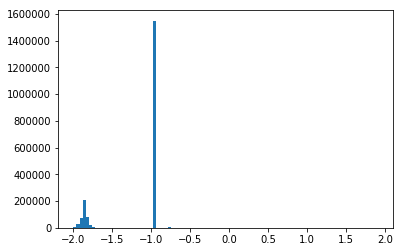

2008 3437859 2688884 [ 0.457  0.782]


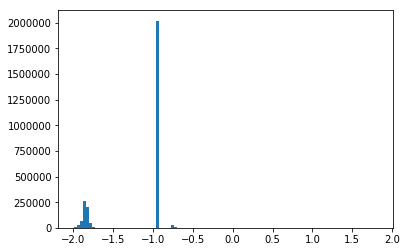

2009 3687558 2692082 [ 0.493  0.73 ]


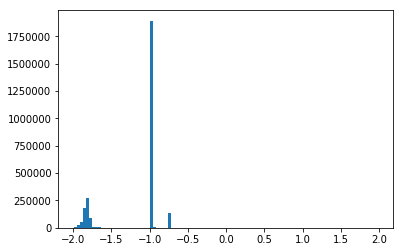

2010 4463626 3288114 [ 0.526  0.737]


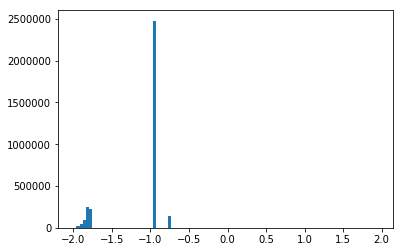

2011 4469110 3198715 [ 0.523  0.716]


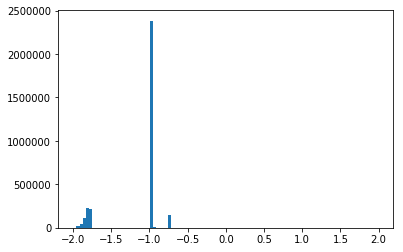

2012 4097473 2957134 [ 0.495  0.722]


2013 4106155 2929358 [ 0.526  0.713]


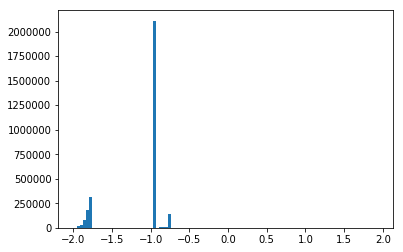

2014 3873948 2655117 [ 0.536  0.685]


2015 5166480 3644074 [ 0.564  0.705]


2016 5262402 3743337 [ 0.569  0.711]


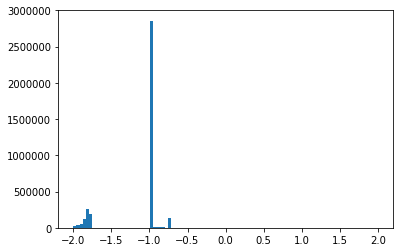

2017 1187053 65964 [ 0.292  0.056]


In [67]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [60]:
print """
    When the two values are not equal, their difference is very large. In the current settings, maximum of them is
    taken. Given that totalassessvalue is about 30+%  weights. tradeoff between of them is signidicant.
    Examintation should be made on their relationshape with sale price.
"""


    When the two values are not equal, their difference is very large. In the current settings, maximum of them is
    taken. Given that totalassessvalue is about 30+%  weights. tradeoff between of them is signidicant.
    Examintation should be made on their relationshape with sale price.



### land vs total

In [68]:
c=get_col('improvementassessedvalue')
d=get_col('landassessedvalue')

In [69]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],4)

2007 23315 134662 5182241 7105306 [ 0.0033  0.019   0.7293  0.2484]
2008 21987 133327 6027661 7515539 [ 0.0029  0.0177  0.802   0.1773]
2009 32040 130662 6273459 7478566 [ 0.0043  0.0175  0.8389  0.1394]
2010 35639 132494 7258868 8488125 [ 0.0042  0.0156  0.8552  0.125 ]
2011 35433 119576 7277283 8549798 [ 0.0041  0.014   0.8512  0.1307]
2012 33857 134125 7001373 8272524 [ 0.0041  0.0162  0.8463  0.1334]
2013 45035 108335 6672928 7812099 [ 0.0058  0.0139  0.8542  0.1262]
2014 46520 108024 6170940 7232700 [ 0.0064  0.0149  0.8532  0.1254]
2015 62444 121373 7893935 9164824 [ 0.0068  0.0132  0.8613  0.1186]
2016 58381 97452 7980296 9247415 [ 0.0063  0.0105  0.863   0.1202]
2017 27829 40956 3433927 4065330 [ 0.0068  0.0101  0.8447  0.1384]


In [71]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 5182241 [ 0.729] 0.0 0.0


2008 6027661 [ 0.802] 0.0 0.0


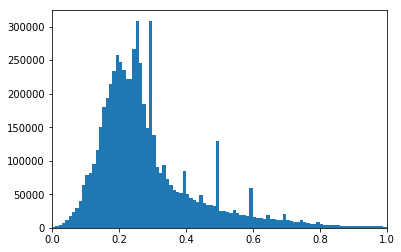

2009 6273459 [ 0.839] 0.0 0.0


2010 7258868 [ 0.855] 0.0 0.0


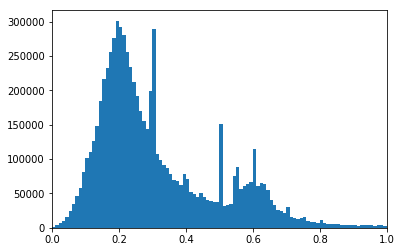

2011 7277283 [ 0.851] 0.0 0.0


2012 7001373 [ 0.846] 0.0 0.0


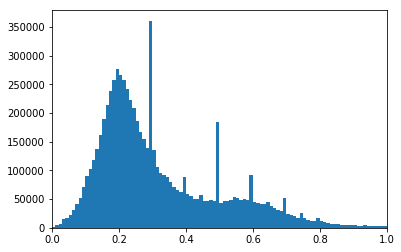

2013 6672928 [ 0.854] 0.0 0.0


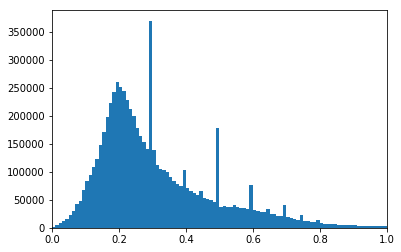

2014 6170940 [ 0.853] 0.0 0.0


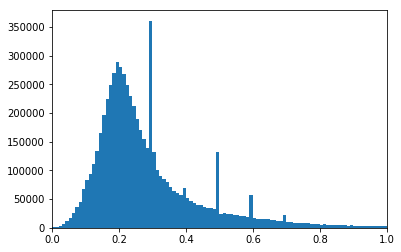

2015 7893935 [ 0.861] 1.26679533085e-07 0.0


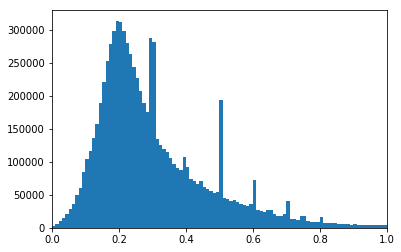

2016 7980296 [ 0.863] 0.0 0.0


2017 3433927 [ 0.845] 0.0 0.0


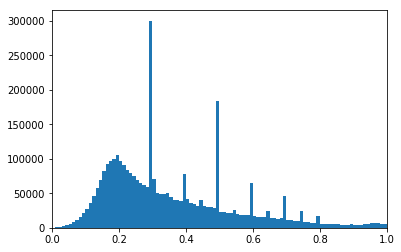

In [76]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [77]:
print """
    There are negative values for 2015. peak for the ratio is 0.2.
    patterns for 2009 to 2013 is a bit different from others.
"""


    There are negative values for 2015. peak for the ratio is 0.2.
    patterns for 2009 to 2013 is a bit different from others.



### land vs total

In [79]:
c=get_col(u'improvementmarketvalue')
d=get_col(u'landmarketvalue')

In [80]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],4)

2007 16796 105804 4071166 7105306 [ 0.0024  0.0149  0.573   0.4098]
2008 18439 108790 4472019 7515539 [ 0.0025  0.0145  0.595   0.388 ]
2009 29939 102033 4393791 7478566 [ 0.004   0.0136  0.5875  0.3948]
2010 35362 125346 5196690 8488125 [ 0.0042  0.0148  0.6122  0.3688]
2011 37108 108111 5232757 8549798 [ 0.0043  0.0126  0.612   0.371 ]
2012 35077 115247 4865806 8272524 [ 0.0042  0.0139  0.5882  0.3936]
2013 41553 106871 4828250 7812099 [ 0.0053  0.0137  0.618   0.363 ]
2014 34752 119483 4498030 7232700 [ 0.0048  0.0165  0.6219  0.3568]
2015 49371 134940 5800023 9164824 [ 0.0054  0.0147  0.6329  0.347 ]
2016 45088 108623 5966954 9247415 [ 0.0049  0.0117  0.6453  0.3381]
2017 13300 52432 1538526 4065330 [ 0.0033  0.0129  0.3785  0.6054]


In [81]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 4071166 [ 0.573] 0.0 0.0


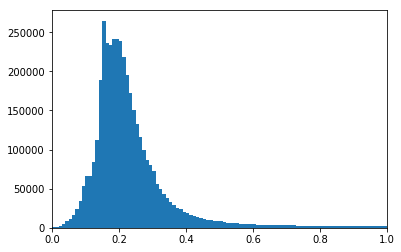

2008 4472019 [ 0.595] 0.0 0.0


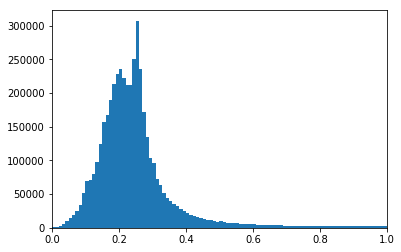

2009 4393791 [ 0.588] 0.0 0.0


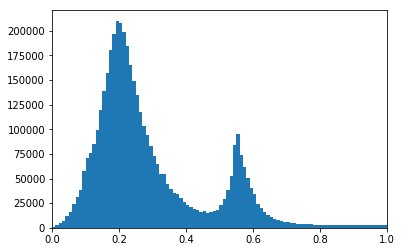

2010 5196690 [ 0.612] 0.0 0.0


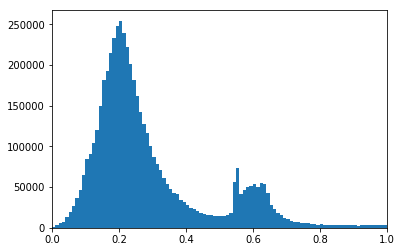

2011 5232757 [ 0.612] 0.0 0.0


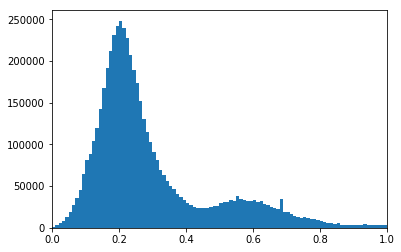

2012 4865806 [ 0.588] 0.0 0.0


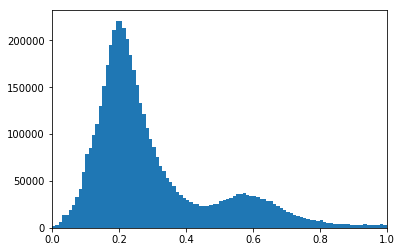

2013 4828250 [ 0.618] 0.0 0.0


2014 4498030 [ 0.622] 0.0 0.0


2015 5800023 [ 0.633] 0.0 0.0


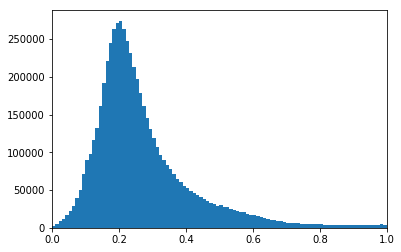

2016 5966954 [ 0.645] 0.0 0.0


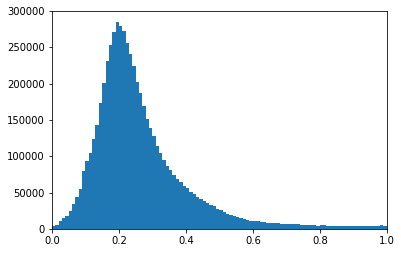

2017 1538526 [ 0.378] 0.0 0.0


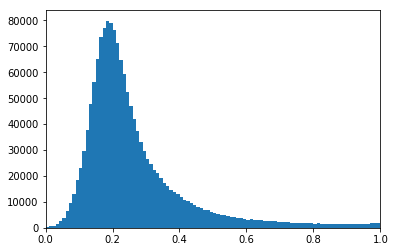

In [82]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [83]:
print """
    There are negative values for 2015. peak for the ratio is 0.2.
    patterns for 2009 to 2013 is a bit different from others.
"""


    There are negative values for 2015. peak for the ratio is 0.2.
    patterns for 2009 to 2013 is a bit different from others.

